<font size=7 face="courier">Cart-Pole Analysis Source Code

This is the code used to create the diagrams in the notebook, `cartpole_analysis.ipynb`. I recommend you at least go through some of these functions to understand how to implement your own analysis functions.

In [1]:
print("Loading: final_analysis_source_code.ipynb...")

Loading: final_analysis_source_code.ipynb...


Import packages

In [51]:
import pandas as pd
import numpy as np
import pickle
import pytz
import sys
import os
import csv
import umap
import json
import random
import zipfile
import glob
import argparse  # Import argparse for command-line arguments
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # For color normalization
import matplotlib.animation as animation

from pathlib import Path
from braingeneers.analysis.analysis import SpikeData
import braingeneers.data.datasets_electrophysiology as ephys


import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d

import gymnasium as gym
import pygame

import spikedata
from spikedata.spikedata import SpikeData
from helper.mapping import Mapping # Moved import higher

from braindance.analysis import data_loader
from braindance.core.spikesorter.rt_sort import RTSort

import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets from IPython.display import HTML, display, Javascript, clear_output,
from IPython.display import HTML, display, Javascript, clear_output

try:
    from braingeneers.utils import smart_open_braingeneers as smart_open
    bgr=True
except:
    print("Could not import smart_open_braingeneers")
    import smart_open
    bgr=False

Here is some minor stuff to help set up the notebook :

In [3]:
Timezone = pytz.timezone("America/Los_Angeles")

# <font color="lightblue"> Loading Data

### 1. Helper Functions

In [4]:
def load_pickle(p):
    with open(p, 'rb') as f:
        data = pickle.load(f)
    return data

def get_save_path(filename_base):
    """Generates a unique save path, appending a number if the file exists."""
    save_path = output_dir / f"{filename_base}.png"
    if save_path.exists():
        n_existing = len(list(output_dir.glob(f"{filename_base}_*.png")))
        save_path = output_dir / f"{filename_base}_{n_existing+1}.png"
    return save_path


### 2. Load Pickled Data

In [5]:
dataset_dir = Path("data")
metadata_path = dataset_dir / 'metadata.pkl'
baseline_sd_path = dataset_dir / 'baseline_spike_data.pkl'
adaptive_sd_path = dataset_dir / 'exp1_cartpole_long_6_spike_data.pkl'
random_sd_path = dataset_dir / 'exp1_cartpole_long_7_spike_data.pkl'
none_sd_path = dataset_dir / 'exp1_cartpole_long_8_spike_data.pkl'
adaptive_logs_path = dataset_dir / 'exp1_cartpole_long_6_logs.pkl'
random_logs_path = dataset_dir / 'exp1_cartpole_long_7_logs.pkl'
none_logs_path = dataset_dir / 'exp1_cartpole_long_8_logs.pkl'
metadata = load_pickle(metadata_path)
baseline_sd = load_pickle(baseline_sd_path)
adaptive_sd = load_pickle(adaptive_sd_path)
adaptive_logs = load_pickle(adaptive_logs_path) # Logs might be needed later
random_sd = load_pickle(random_sd_path)
random_logs = load_pickle(random_logs_path)
none_sd = load_pickle(none_sd_path)
none_logs = load_pickle(none_logs_path)

### 3. Example of more data extraction

In [6]:
# --- Data Extraction ---
mapping = metadata['mapping']
encode_electrodes = metadata['encode_electrodes']
decode_electrodes = metadata['decode_electrodes']
training_electrodes = metadata['training_electrodes']
spike_channels = metadata['spike_channels'] # List of arrays
spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

# Ensure spike_locs is a numpy array for easier slicing
spike_locs = np.array(spike_locs)
spikes_x = spike_locs[:, 0]
spikes_y = spike_locs[:, 1]

# --- Mapping and Positions ---
mapper = Mapping().from_df(mapping)
encode_positions = mapper.get_positions(electrodes=encode_electrodes)
decode_positions = mapper.get_positions(electrodes=decode_electrodes)
training_positions = mapper.get_positions(electrodes=training_electrodes)
all_positions = mapper.get_positions()

In [7]:
datasets = ["Baseline", "Dataset 6", "Dataset 7", "Dataset 8"]
#sd_main = baseline_sd
#logs_main = 0

def dataSelect(sd_name):
    global sd_main
    global logs_main
    msg = "Successfully loaded " + sd_name + " logs into : <logs_main>"
    if sd_name == "Baseline":
        sd_main = baseline_sd
        print("Warning: no logs provided, some functions may not work for this data")
        msg = "No logs loaded: <logs_main = -1>"
        logs_main = -1
    elif sd_name == "Dataset 6":
        sd_main = adaptive_sd
        logs_main = adaptive_logs
    elif sd_name == "Dataset 7":
        sd_main = random_sd
        logs_main = random_sd
    elif sd_name == "Dataset 8": 
        sd_main = none_sd
        logs_main = none_logs
    else:
        raise Exception("Invalid data selection")
    print("Successfully loaded " + sd_name + " into : <sd_main>")
    print(msg)
    return

# interact_manual( dataSelect, sd_name=datasets )

# <font color="lightblue">Stim Pulses

## <font color="red">Legacy

Prebuilt function used to plot the square wave stimulation example shown in the notebook :

In [8]:
def plotPulse():
    t,signal =  getTimeSignal(60)
    signal = squareWave( signal, time_s=1, phase_us=200, amp_mV=150 )

    plt.plot(t,signal)
    plt.xlim([.998,1.002])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.show()

## <font color="lightblue"> General Stim Functions

In [9]:
def plotStimPattern(signal,t):
    plt.plot(t,signal.T)
    plt.legend(['n0','n1','n2'])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.title("Stim Pattern over 1 Second")
    plt.show()

In [10]:
def plotIndividualPatterns(signal,t):
    names=["n0","n1","n2"]
    color=["b","#F97306","g"]
    plt.figure(figsize=(16,4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.plot(t,signal[i], color=color[i])
        plt.legend([f"n{i}"])
        plt.ylabel('Voltage (mv)')
        plt.xlabel('seconds')
        plt.show

A helper function used in `create_stim_pulse_sequence`

In [11]:
def insert_square_wave_advanced(sig,time,phase_length=20, amplitude=1):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+phase_length] = amplitude
    sig[time+phase_length:time+phase_length*2] = -amplitude
    return sig

Main function used to create stim pulse sequences :

In [12]:
def create_stim_pulse_sequence(stim_list, freq_Hz=None, time_arr = None,max_time_s = 1):
    """
    Creates a stim pulse sequence, parallels the real code that will run on the Maxwell
    
    Params:
    stim_list - list of tuples indicating the commands to run
            ------------------------------------------------
            For 'stim' command:
            ('stim', [neuron inds], mv, us per phase)

            For 'delay'
            ('delay', frames_delay)
            
            For 'next'
            ('next', None)
            This command acts as a placeholder to move to the next timepoint in the time_arr or the next
            period triggered by the freq_Hz
            -------------------------------------------------
    freq_Hz - frequency to call the top stim_list in
            *Note* this takes priority over time_arr
    time_arr - array of time values that will be when the stimulations occur in order
    
    max_time_s - time in seconds to stimulate
    
    
    Returns:
    sig - np.array -- shape=(n_neurons, timesteps) of what the signal will look like
    t - np.array   -- shape=(timesteps) of time in seconds
    """
    
    # Since this is fake, only parallels the code on the device,
    # We have to make our own time
    # And simulate what the stimulation will look like
    
    # Conversion paramerters
    fs_ms = 20 # Good for converting frames to ms
    fs_us = .2
    
    # stim list
    seq = ('next',None)
    stim_list.append(seq)
    stim_list=stim_list*freq_Hz
    
    # Setup
    fs = 20000
    n_neurons = 3
    t = np.arange(0,fs*max_time_s)/fs
    sig = np.zeros(shape=(n_neurons,t.shape[0]))
    
    
    # This would be generated in *real time*
    if freq_Hz is not None:
        # Until the time is right to stimulation the sequence
        for time in t[::fs//freq_Hz]:
            time_frames = int(time*fs)
            
            
            if len(stim_list) == 0:
                return sig
            
            #Build the sequence
            command = None
            
            while (command != 'next'):
                command, *params = stim_list.pop(0) # Get first thing off list
                if command == 'stim':
                    neurons, amplitude, phase_length = params
                    phase_length = int(phase_length*fs_us)
                    
                    # Change signal for each neuron
                    for n in neurons:
                        sig[n,:] = insert_square_wave_advanced(sig[n,:],time_frames,phase_length, amplitude=amplitude)
                    time_frames += phase_length*2
                    
                if command == 'delay':
                    time_frames += fs_ms*params[0]
                    
                #double checking here
                if command == 'next':
                    break 
                    
        return sig,t

Example

In [13]:
# stim_pattern = []
# stim_pattern.append(('stim',[0],150,200))
# stim_pattern.append(('delay',20))
# stim_pattern.append(('stim',[1],200,20))
# #stim_pattern.append(('delay',250))
# #stim_pattern.append(('stim',[0,1,2],150,20))
# signal,t = create_stim_pulse_sequence(stim_pattern, freq_Hz=1)

# <font color="Green"> Analysis Plots

Here is the source code for all the figures used in the main notebook. Feel free to use these as reference/inspiration when working on your own analysis methods!

## <font color="Green">Generic Analysis


In [14]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

def raster_analysis(sd, seconds=20):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='r')

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()

    raster_analysis(sd_main, sd_main.length/1000)


In [15]:
def plot_raster_pretty(sd, title="Spike Raster", l1=-10, l2=False, xsize=20, ysize=6, analyze=False):
    """
    Plots a configuable raster plot of the spike data.
        sd : spike data object from braingeneers
        title : Title of the plot
        l1 : start time in seconds
        l2 : end time in seconds
        xsize : width of the plot
        ysize : height of the plot
        analyze : If True, will plot the population rate as well
    """

    if l2==False:
        l2 = sd.length / 1000 + 10
    
    idces, times = sd.idces_times()
    
    if analyze == True:
        # Get population rate for everything
        pop_rate = sd.binned(bin_size=1)  # in ms
        # Lets smooth this to make it neater
        sigma = 5
        pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
        t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

        # Determine the stop_time if it's not provided
        if l2 is None:
            l2 = t[-1]

        # Filter times and idces within the specified start and stop times
        mask = (times >= l1 * 1000) & (times <= l2 * 1000)
        times = times[mask]
        idces = idces[mask]

    fig, ax = plt.subplots(figsize=(xsize, ysize))
    fig.suptitle(title)
    ax.scatter(times/1000,idces,marker='|',s=1)
    
    if analyze == True:
        ax2 = ax.twinx()
        ax2.plot(t, pop_rate_smooth, c='r', alpha=0.6)
        ax2.set_ylabel('Firing Rate')
        
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.xlim(l1, l2)
    plt.show()

#plot_raster_pretty(sd_main, analize=True)

In [16]:
def interspike(sd):
    # Interspike-intervals of 2 select neurons
    isis_raw = sd.interspike_intervals()
    # Remove all isi's greater than 100ms. As there are likely neurons not following periodic firing pattern
    isis=[]
    for i in range(len(isis_raw)):   
        isi=isis_raw[i]
        isis = isis + isi[isi<100].tolist() 
        
    # Plot the isi's
    plt.xlim(0,100)
    plt.hist(isis, bins=50)
    plt.xlabel('Time bin(ms)')
    plt.ylabel('ISI count')
    plt.show()

#interspike(sd_main)

In [17]:
def get_sttc(sd):
    """
    Returns the spike time tiling coefficient of a spike data object
        sd : spike data object from braingeneers
        returns : N x N matrix of STTC values
    """

    sttc = sd.spike_time_tilings()
    sttc = np.nan_to_num(sttc)

    return sttc

def correlation(sd):
    """
    Returns the correlation matrix of a spike data object
        sd : spike data object from braingeneers
        returns : N x N matrix of correlation values
    """
    
    corr = np.zeros((sd.N,sd.N)) #inds by inds
    
    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma)
    corr=np.corrcoef( dense_raster )
    corr = np.nan_to_num(corr) 

    return corr;

def eigenvalues_eigenvectors(sd): # gets the eigenvalues and eigenvectors of a matrix
    """
    returns the eigenvalues and eigenvectors of a matrix
        sd : spike data object from braingeneers
        returns : eigenvalues, eigenvectors
    """

    W, U = np.linalg.eigh(sd)
    # The rank of A can be no greater than the smaller of its
    # dimensions, so cut off the returned values there.
    rank = min(*sd.shape)
    U = U[:,-rank:]
    sgn = (-1)**(U[0,:] < 0)
    # Also reverse the order of the eigenvalues because eigh()
    # returns them in ascending order but descending makes more sense.
    return W[-rank:][::-1], (U*sgn[np.newaxis,:])[:, ::-1]


In [18]:
def correlation_plot(sd):
    # Correlation
    
    corr = correlation(sd)

    im = plt.imshow(corr)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show() 

def STTC_plot(sd):
    # STTC

    sttc = get_sttc(sd)

    im = plt.imshow(sttc)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.colorbar(im, fraction=0.046, pad=0.04)  # Add colorbar
    plt.show() 

def plot_evectmatrix(sd):
    """
    Plots the eigenvectors of the correlation and STTC matrices for a given spike data object.
        sd : spike data object from braingeneers
    """
    
    fig, plot = plt.subplot_mosaic("AB", figsize=(14,7))
    
    corr = correlation(sd)
    sttc = get_sttc(sd)

    Wcorr, Ucorr = eigenvalues_eigenvectors(corr)
    Wsttc, Usttc = eigenvalues_eigenvectors(sttc)

    # Plot Correlation Matrix
    pltA = plot["A"].imshow(Ucorr[:,:2*len(Ucorr)].T, interpolation='none', cmap="magma")
    #plot["A"].gca().set_aspect('auto')
    plot["A"].set_ylabel('Eigenvector Number')
    plot["A"].set_xlabel('Observation Dimension')
    plot["A"].set_title('Eigenvectors of Correlation')
    fig.colorbar(pltA, ax=plot["A"], shrink=0.7)
    
    # Plot STTC matrix
    pltA = plot["B"].imshow(Usttc[:,:2*len(Usttc)].T, interpolation='none', cmap="magma")
    #plot["B"].gca().set_aspect('auto')
    plot["B"].set_ylabel('Eigenvector Number')
    plot["B"].set_xlabel('Observation Dimension')
    plot["B"].set_title('Eigenvectors of STTC')
    fig.colorbar(pltA, ax=plot["B"], shrink=0.7)

#correlation_plot(sd_main)
#STTC_plot(sd_main)
#plot_evectmatrix(sd_main)

In [19]:
def plot_basis(method):
    
    if method == "Correlation":
        Corr = correlation(sd_main)

        Wcorr, Ucorr = eigenvalues_eigenvectors(Corr)
        A = Ucorr
    else:
        STTC = get_sttc(sd_main)

        Wsttc, Usttc = eigenvalues_eigenvectors(STTC)
        A = Usttc
        
    plt.figure(figsize=(6,8))
    for i in range(5):
        if i: plt.xticks([])
        plt.subplot(5, 1, i+1)
        plt.stem(A[:,i])
    plt.xlabel('Observation Dimension')
    plt.suptitle('First 5 Eigenvectors', y=0.92)  

In [20]:
def PCAplots(corr, sttc):
    plt.figure(figsize=(7,5))
    plt.scatter(corr[0], corr[1]) # first two eigenvectors of correlation 
    plt.scatter(sttc[0], sttc[1]) # first two eigenvectors of STTC
    plt.legend(["Correlation Eigenvectors", "STTC Eigenvectors"])
    plt.title("Principle Components Analysis of Correlation Methods")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

In [21]:
def reconstruct(W, U, rank):
    Wd = np.diag(W[:rank])
    Ur = U[:, :rank]
    return Ur @ Wd @ Ur.T
    
def reconstruction_errors(A, ranks):
    norm = np.linalg.norm(A)
    W, U = eigenvalues_eigenvectors(A)
    return np.array([
        np.linalg.norm( reconstruct(W, U, rank) - A) / norm
        for rank in ranks])
    
def ReconstructPlots(Wcorr, Wsttc, Corr, STTC):
    fig, plot = plt.subplot_mosaic("AB", figsize=(15,5)) 
    
    # Eigenvalue spectrum ---------------------------------------------------------
    index = 1 + np.arange(len(Wcorr))
    plot["A"].semilogy(index, Wcorr, label='Correlation')
    plot["A"].plot(index, Wsttc, label='STTC')
    plot["A"].set_title('Eigenvalue Spectrum')
    plot["A"].set_xlabel('Index')
    plot["A"].set_ylabel('Eigenvalue')
    plot["A"].axvline(len(Wcorr)+1, ls=':', c='k')
    plot["A"].legend(loc="upper right");
    
    # Reconstruction Error --------------------------------------------------------
    errs_corr = reconstruction_errors(Corr, range(len(Corr)))      # Correlation
    errs_sttc = reconstruction_errors(STTC , range(len(STTC)))     # STTC   
    
    plot["B"].plot(errs_corr, label='Correlation Matrix')          # Correlation
    plot["B"].plot(errs_sttc, label='STTC Matrix')                 # STTC
    
    plot["B"].set_title("Reconstruction Error of Correlation Methods")
    plot["B"].set_xlabel('Components Used in Reconstruction')
    plot["B"].set_ylabel('Relative Reconstruction Error')
    plot["B"].legend(loc="upper right");
    fig.show()

In [22]:
def EigenvectorAnalysis(corr, sttc):

    plot_color = "magma"
    """figLayout = 
                AAABBB
                CCCDDD
                CCCDDD
                CCCDDD
                """
    
    figLayout = """
                AABB
                CCDD
                CCDD
                """
    
    fig, plot = plt.subplot_mosaic(figLayout, figsize=(16,8))
    fig.tight_layout(pad=5.0)
    
    # Plot Correlation basis
    plot["A"].stem(corr[:,0])
    plot["A"].set_xlabel('Observation Dimension')
    plot["A"].set_title('First Eigenvector of Correlation')    
    
    # Plot STTC basis
    plot["B"].stem(sttc[:,0])
    plot["B"].set_xlabel('Observation Dimension')
    plot["B"].set_title('First Eigenvector of STTC')    
    
    # Plot Correlation Matrix
    pltC = plot["C"].imshow(corr[:,:2*len(corr)].T, interpolation='none', cmap=plot_color)
    #plot["A"].gca().set_aspect('auto')
    plot["C"].set_ylabel('Eigenvector Number')
    plot["C"].set_xlabel('Observation Dimension')
    plot["C"].set_title('Eigenvectors of Correlation')
    fig.colorbar(pltC, ax=plot["C"], shrink=0.7)
    
    # Plot STTC matrix
    pltD = plot["D"].imshow(sttc[:,:2*len(sttc)].T, interpolation='none', cmap=plot_color)
    #plot["B"].gca().set_aspect('auto')
    plot["D"].set_ylabel('Eigenvector Number')
    plot["D"].set_xlabel('Observation Dimension')
    plot["D"].set_title('Eigenvectors of STTC')
    fig.colorbar(pltD, ax=plot["D"], shrink=0.7)

In [23]:
def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)
    return np.array(mean_firing_rates)

### <font color="lightblue"> Mappings

#### <font color="lightblue">electrode_layout</font> 

plots the placement of all the recording electrodes

In [24]:
electrode_mapping = metadata['mapping']

def electrodeLayout():
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values

    plt.figure(figsize=(10,5))
    plt.scatter(x,y,s=2)
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

In [25]:
# electrodeLayout()

#### <font color="lightblue">neuronLayout</font> 

Plots the putative neural units found from spike sorting

In [26]:
spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

# Ensure spike_locs is a numpy array for easier slicing
spike_locs = np.array(spike_locs)
spikes_x = spike_locs[:, 0]
spikes_y = spike_locs[:, 1]

def neuronLayout(sd):
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values

    plt.figure(figsize=(10,5))
    plt.scatter(x,y,s=2)

    neuron_x = spikes_x
    neuron_y = spikes_y

    plt.scatter(neuron_x,neuron_y,c='r')
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

In [27]:
# neuronLayout(baseline_sd)

#### <font color="lightblue">sttcLayout

Show which neurons are connected via spike time tiling

In [ ]:
def sttcLayout( threshold ):
    # Lets bring back our graph, and overlay these as connectivity lines

    sttc = sd_main.spike_time_tilings()
    # electrodes
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values
    
    neuron_x = spikes_x
    neuron_y = spikes_y
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.scatter(x,y,s=2)
    # Neurons
    plt.scatter(neuron_x,neuron_y,c='r')

    # Now lines for each neuron if above threshhold
    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):

            # Only need to do upper triangle since sttc' = sttc
            if i<=j: continue

            if sttc[i,j] < threshold : continue

            #Position of neuron i
            ix,iy = spikes_x[i],spikes_y[i]
            jx,jy = spikes_x[j],spikes_y[j]

            # Plot line between the points, linewidth is the sttc
            plt.plot([ix,jx],[iy,jy], linewidth=sttc[i,j],c='k')

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    
    

    plt.subplot(1, 2, 2)
    sttc[sttc<threshold ] = 0
    plt.imshow(sttc,vmin=0,vmax=1)
    plt.colorbar()
    plt.title("Spike Time Tiling")
    plt.show()

In [29]:
# sttcLayout(baseline_sd, .2)

#### <font color="lightblue">Latency Plots

Displays two plots. The left plot shows which two points the latencies are being calculated between. The right plot is a histogram of all the latencies between the points.


In [30]:
def latencyPlots(neuron1, neuron2):
    
    sd = sd_main

    # Create plot of neural units with selected neurons for latency calculation in green
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values
    plt.scatter(x,y,s=2)

    neuron_x = spikes_x
    neuron_y = spikes_y

    plt.scatter(neuron_x,neuron_y,c='r')
    plt.scatter(neuron_x,neuron_y,c='r')

    plt.scatter([neuron_x[neuron1]],[neuron_y[neuron1]],s=70,c='g')
    plt.scatter([neuron_x[neuron2]],[neuron_y[neuron2]],s=70,c='g')

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    #plt.show()
    
    # Plot Histogram of latencies
    plt.subplot(1, 2, 2)
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw = lates_n1[neuron2]
    lates =  list(filter(lambda x: x < 10 and x > -10, lates_raw ))
    plt.hist(lates,bins=8)
    #plt.xlim([-25,25])
    print("Mean Latency: ", np.mean(lates) )
    print("Number of Latencies: ", len(lates))
    plt.show()

#### <font color="lightblue"> Eigenvector Mapping

In [31]:
def evectLayout(sd, vect, threshold=0):
    plot_color = "magma"
    #x = electrode_mapping.x.values
    #y = electrode_mapping.y.values

    sttc = sd.spike_time_tilings()
    firing_rates = calculate_mean_firing_rates(sd)
    
    neuron_x = spikes_x
    neuron_y = spikes_y
    
    plt.figure(figsize=(10,5)) 
    ax = plt.axes()
    ax.set_facecolor("grey")
    #plt.scatter(neuron_x,neuron_y, s=neuron_amp, c=vect, cmap = plot_color) # color each plotted neuron according to the values of the eigenvector
    plt.scatter(neuron_x,neuron_y, c=vect, cmap = plot_color) # color each plotted neuron according to the values of the eigenvector
   
    
    for i in range(sttc.shape[0]): # plot connectivity lines between neurons
        for j in range(sttc.shape[1]):

            # Only need to do upper triangle since sttc' = sttc
            if i<=j: continue

            if sttc[i,j] < threshold : continue

            #Position of neuron i
            ix,iy = spikes_x[i],spikes_y[i]
            jx,jy = spikes_x[j],spikes_y[j]

            # Plot line between the points, linewidth is the sttc
            plt.plot([ix,jx],[iy,jy], linewidth=sttc[i,j],c='k')
            
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("Neuron layout")
    plt.colorbar()
    plt.show()

Settings for the mapping plot:

In [32]:
method_options = ["Correlation", "Spike Time Tiling"]

def EigenvectorLayout(Method):
    global ELayout_usemethod;
    
    if Method == "Correlation":
        Corr = correlation(sd)
        Wcorr, Ucorr = eigenvalues_eigenvectors(Corr)
        ELayout_usemethod = Ucorr
    else:
        STTC = get_sttc(sd)
        Wsttc, Usttc = eigenvalues_eigenvectors(STTC)
        ELayout_usemethod = Usttc
        
    interact_manual( vectorSelect, Vector=(0,len(ELayout_usemethod),1), thresholdIn=(0,1,0.01)) 

In [33]:
def vectorSelect(Vector, thresholdIn):
    evectLayout(sd_main, ELayout_usemethod[:,Vector], thresholdIn)

In [34]:
def vectorSelectV2(Vector):
    evectLayout(sd_main, ELayout_usemethod[:,Vector])

#### <Font color="lightblue"> MEA Encode/Decode/Train Architecture Map

In [35]:
def Architecture_Map():
    mapping = metadata['mapping']
    encode_electrodes = metadata['encode_electrodes']
    decode_electrodes = metadata['decode_electrodes']
    training_electrodes = metadata['training_electrodes']
    spike_channels = metadata['spike_channels'] # List of arrays
    spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

    # Ensure spike_locs is a numpy array for easier slicing
    spike_locs = np.array(spike_locs)
    spikes_x = spike_locs[:, 0]
    spikes_y = spike_locs[:, 1]

    print(len(spikes_x))

    # --- Mapping and Positions ---
    mapper = Mapping().from_df(mapping)
    encode_positions = mapper.get_positions(electrodes=encode_electrodes)
    decode_positions = mapper.get_positions(electrodes=decode_electrodes)
    training_positions = mapper.get_positions(electrodes=training_electrodes)
    all_positions = mapper.get_positions()

    # ====== Plot 1: Electrode Roles ======
    print("Generating Electrode Role Plot...")
    fig_roles, ax_roles = plt.subplots(figsize=(10, 5))
    ax_roles.scatter(all_positions[:, 0], all_positions[:, 1], s=2,
                    label='Unused', zorder=-2)
    ax_roles.scatter(encode_positions[:, 0], encode_positions[:, 1], c='blue',
                    label='Encode', s=60, marker='X', alpha=0.8)
    ax_roles.scatter(decode_positions[:, 0], decode_positions[:, 1], c='g',
                    label='Decode', s=60, marker='o', alpha=0.8, facecolors='none', linewidths=1.5)
    ax_roles.scatter(training_positions[:, 0], training_positions[:, 1], c='purple',
                    label='Training', s=60, marker='s', alpha=0.8, facecolors='none', linewidths=1.5)

    ax_roles.set_title('Electrode Roles on Array')
    ax_roles.set_xlabel('X Position (µm)')
    ax_roles.set_ylabel('Y Position (µm)')
    ax_roles.legend(loc='upper right')
    ax_roles.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
    plt.tight_layout()
    plt.show()

#Architecture_Map()

#### <font color="lightblue"> Combined MEA Map With Neurons

In [36]:
def Combined_Map():
    mapping = metadata['mapping']
    encode_electrodes = metadata['encode_electrodes']
    decode_electrodes = metadata['decode_electrodes']
    training_electrodes = metadata['training_electrodes']
    spike_channels = metadata['spike_channels'] # List of arrays
    spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

    # Ensure spike_locs is a numpy array for easier slicing
    spike_locs = np.array(spike_locs)
    spikes_x = spike_locs[:, 0]
    spikes_y = spike_locs[:, 1]

    print(len(spikes_x))

    # --- Mapping and Positions ---
    mapper = Mapping().from_df(mapping)
    encode_positions = mapper.get_positions(electrodes=encode_electrodes)
    decode_positions = mapper.get_positions(electrodes=decode_electrodes)
    training_positions = mapper.get_positions(electrodes=training_electrodes)
    all_positions = mapper.get_positions()


    neuron_x = spikes_x
    neuron_y = spikes_y

    # ====== Plot 1: Electrode Roles ======
    print("Generating Electrode Role Plot...")
    fig_roles, ax_roles = plt.subplots(figsize=(10, 5))
    ax_roles.scatter(all_positions[:, 0], all_positions[:, 1], s=2,
                    label='Unused', zorder=-3)
    ax_roles.scatter(encode_positions[:, 0], encode_positions[:, 1], c='blue',
                    label='Encode', s=60, marker='X', alpha=1)
    ax_roles.scatter(decode_positions[:, 0], decode_positions[:, 1], c='g',
                    label='Decode', s=60, marker='o', alpha=0.8, facecolors='none', linewidths=1.5)
    ax_roles.scatter(training_positions[:, 0], training_positions[:, 1], c='purple',
                    label='Training', s=60, marker='s', alpha=0.8, facecolors='none', linewidths=1.5)
    ax_roles.scatter(neuron_x, neuron_y, label='Neural Unit', c="r", alpha=0.6, zorder=-2)

    ax_roles.set_title('Electrode Roles on Array')
    ax_roles.set_xlabel('X Position (µm)')
    ax_roles.set_ylabel('Y Position (µm)')
    ax_roles.legend(loc='upper right')
    ax_roles.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
    plt.tight_layout()
    plt.show()

#Combined_Map()

### <font color="lightblue"> Dimension Reduction Plots

In [37]:
output_dir = Path(os.path.join("saved_plots"))

Helper Function To Create Rate Matrices From Spiking Data. <br>
You can define the bin size in milliseconds and a smoothing window.

In [38]:
# New code for UMAP embedding and animation ----------------

def create_rate_matrices(sd, bin_size_ms=50, smoothing_window=3):
    """Create binned rate matrices from spike data"""
    # Calculate number of bins
    n_bins = int(sd.length // bin_size_ms) + 1
    
    # Create time bins
    bins = np.linspace(0, sd.length, n_bins)
    
    # Get spike times and indices
    indices, times = sd.idces_times()
    
    # Create rate matrix
    rate_matrix = np.zeros((sd.N, n_bins-1))
    
    # Bin spikes
    for i in range(sd.N):
        mask = indices == i
        neuron_times = times[mask]
        hist, _ = np.histogram(neuron_times, bins=bins)
        rate_matrix[i, :] = hist
    
    # Convert to firing rate (Hz)
    rate_matrix = rate_matrix * (1000 / bin_size_ms)
    
    # Apply smoothing if requested
    if smoothing_window > 0:
        from scipy.ndimage import gaussian_filter1d
        for i in range(rate_matrix.shape[0]):
            rate_matrix[i, :] = gaussian_filter1d(rate_matrix[i, :], smoothing_window)
    
    # Return rate matrix and time bins
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return rate_matrix, bin_centers

Create the rate matrices from spiking data

In [39]:
print("Creating rate matrices...")
adaptive_rates, adaptive_times = create_rate_matrices(adaptive_sd)
random_rates, random_times = create_rate_matrices(random_sd)
none_rates, none_times = create_rate_matrices(none_sd)

# Transpose to get time points as rows, neurons as columns
adaptive_rates_t = adaptive_rates.T
random_rates_t = random_rates.T
none_rates_t = none_rates.T

Creating rate matrices...


Fit and transform the data using UMAP and PCA to get the embeddings. The data is first transformed with PCA if `do_pca` is True to save computation time as PCA is faster than UMAP

In [40]:
print("Fitting UMAP model...")
# Create a single UMAP model for all datasets
combined_data = np.vstack([adaptive_rates_t, random_rates_t, none_rates_t])

# if PCA before UMAP
do_pca = True

if do_pca:
    print("\nRunning PCA...")
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    combined_data = scaler.fit_transform(combined_data)
    pca = PCA(n_components=.70)
    combined_data = pca.fit_transform(combined_data)

    # Plot PCA uick
    # plt.plot(np.ca


print('\nRunning UMAP')
# Fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
combined_embedding = umap_model.fit_transform(combined_data)

# Split back into individual embeddings
n_adaptive = adaptive_rates_t.shape[0]
n_random = random_rates_t.shape[0]
n_none = none_rates_t.shape[0]

adaptive_embedding = combined_embedding[:n_adaptive]
random_embedding = combined_embedding[n_adaptive:n_adaptive+n_random]
none_embedding = combined_embedding[n_adaptive+n_random:]


Fitting UMAP model...

Running PCA...

Running UMAP


We will be coloring these points based off of their rewards and pole angle so we need to extract these from the data to a plottable form

In [41]:
# Get reward values for coloring the points
def extract_rewards(logs, embedding_length):
    """Extract reward values from logs"""
    if 'reward' in logs:
        rewards = logs['reward']['reward'].values
        # Interpolate to match the number of embedding points
        from scipy.interpolate import interp1d
        x_orig = np.linspace(0, 1, len(rewards))
        x_new = np.linspace(0, 1, embedding_length)
        interp_func = interp1d(x_orig, rewards, bounds_error=False, fill_value="extrapolate")
        return interp_func(x_new)
    return np.zeros(embedding_length)

# Get pole angle values for coloring the points
def extract_pole_angles(logs, embedding_length):
    """Extract pole angle values from logs"""
    if 'game' in logs and 'theta' in logs['game']:
        angles = logs['game']['theta'].values
        # Interpolate to match the number of embedding points
        from scipy.interpolate import interp1d
        x_orig = np.linspace(0, 1, len(angles))
        x_new = np.linspace(0, 1, embedding_length)
        interp_func = interp1d(x_orig, angles, bounds_error=False, fill_value="extrapolate")
        return interp_func(x_new)
    return np.zeros(embedding_length)

print("Extracting rewards and pole angles...")
# Fix: Pass the correct embedding length to each extraction function
adaptive_rewards = extract_rewards(adaptive_logs, len(adaptive_embedding))
random_rewards = extract_rewards(random_logs, len(random_embedding))
none_rewards = extract_rewards(none_logs, len(none_embedding))

adaptive_angles = extract_pole_angles(adaptive_logs, len(adaptive_embedding))
random_angles = extract_pole_angles(random_logs, len(random_embedding))
none_angles = extract_pole_angles(none_logs, len(none_embedding))


Extracting rewards and pole angles...


Function to plot embeddings colored by rewards

In [42]:
# vmax controls the max reward that equals to highest intensity for coloring
# setting it to None scales it so to each particular graph
# setting it to a number like 150 will make it the same across all 3 subplots
def umap_embeddings_rewards(vmax=150, save_fig=False):

    # Show a static plot of the embeddings
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.scatter(adaptive_embedding[:, 0], adaptive_embedding[:, 1], c=adaptive_rewards, 
            cmap='viridis', s=3, alpha=0.7, vmin=0, vmax=vmax)
    plt.colorbar(label='Reward')
    plt.title('Adaptive Stimulus')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    plt.subplot(1, 3, 2)
    plt.scatter(random_embedding[:, 0], random_embedding[:, 1], c=random_rewards, 
            cmap='viridis', s=3, alpha=0.7, vmin=0, vmax=vmax)
    plt.colorbar(label='Reward')
    plt.title('Random Stimulus')
    plt.xlabel('UMAP 1')

    plt.subplot(1, 3, 3)
    plt.scatter(none_embedding[:, 0], none_embedding[:, 1], c=none_rewards, 
            cmap='viridis', s=3, alpha=0.7, vmin=0, vmax=vmax)
    plt.colorbar(label='Reward')
    plt.title('No Stimulus')
    plt.xlabel('UMAP 1')

    plt.tight_layout()

    if save_fig:
        static_reward_file = output_dir / "neural_embedding_reward_static.png"

        # If exists, add a number to the end
        if static_reward_file.exists():
                n_existing = len(glob.glob(str(output_dir / "neural_embedding_reward_static*.png")))
                static_reward_file = output_dir / f"neural_embedding_reward_static{n_existing+1}.png"

        plt.savefig(str(static_reward_file), dpi=150)

        print(f"Static plot saved to {static_reward_file}")

    plt.show()
    plt.close()


# umap_embeddings_rewards(vmax=None)

Function to plot trajectories colored by rewards

In [43]:
def umap_trajectory_rewards(vmax=150, save_fig=False):

    # ---------------- Show static plots with TRAJECTORY lines colored by rewards ----------------
    print("Generating static trajectory plot colored by reward...")
    fig_traj, axs_traj = plt.subplots(1, 3, figsize=(18, 6))
    fig_traj.suptitle('Neural Trajectories Colored by Reward', fontsize=16)

    # Use the same colormap and normalization as the animation/other static plot
    reward_cmap = plt.get_cmap('viridis')
    reward_norm = plt.Normalize(vmin=0, vmax=vmax) # vmax is already defined as 150

    # --- Adaptive Plot ---
    axs_traj[0].set_title('Adaptive Stimulus')
    # Plot scatter points (optional, can be removed if only lines are desired)
    # axs_traj[0].scatter(adaptive_embedding[:, 0], adaptive_embedding[:, 1], c=adaptive_rewards,
    #                     cmap=reward_cmap, norm=reward_norm, s=1, alpha=0.5)
    # Plot trajectory lines
    for i in range(1, len(adaptive_embedding)):
        color = reward_cmap(reward_norm(adaptive_rewards[i]))
        axs_traj[0].plot(adaptive_embedding[i-1:i+1, 0], adaptive_embedding[i-1:i+1, 1],
                        color=color, lw=0.5, alpha=0.3)

    # --- Random Plot ---
    axs_traj[1].set_title('Random Stimulus')
    # axs_traj[1].scatter(random_embedding[:, 0], random_embedding[:, 1], c=random_rewards,
    #                     cmap=reward_cmap, norm=reward_norm, s=1, alpha=0.5)
    for i in range(1, len(random_embedding)):
        color = reward_cmap(reward_norm(random_rewards[i]))
        axs_traj[1].plot(random_embedding[i-1:i+1, 0], random_embedding[i-1:i+1, 1],
                        color=color, lw=0.5, alpha=0.3)

    # --- None Plot ---
    axs_traj[2].set_title('No Stimulus')
    # axs_traj[2].scatter(none_embedding[:, 0], none_embedding[:, 1], c=none_rewards,
    #                     cmap=reward_cmap, norm=reward_norm, s=1, alpha=0.5)
    for i in range(1, len(none_embedding)):
        color = reward_cmap(reward_norm(none_rewards[i]))
        axs_traj[2].plot(none_embedding[i-1:i+1, 0], none_embedding[i-1:i+1, 1],
                        color=color, lw=0.5, alpha=0.3)

    # Add labels and colorbars
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    for i, ax in enumerate(axs_traj):
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        # Create a ScalarMappable for the colorbar
        sm = plt.cm.ScalarMappable(cmap=reward_cmap, norm=reward_norm)
        sm.set_array([]) # You need to set an empty array for it to work
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(sm, cax=cax)
        cbar.set_label('Reward')

    fig_traj.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout

    if save_fig:
        # Save the new static plot
        static_traj_file = output_dir / "neural_trajectory_reward_static.png"
        # If exists, add a number to the end
        if static_traj_file.exists():
            n_existing = len(glob.glob(str(output_dir / "neural_trajectory_reward_static_*.png")))
            static_traj_file = output_dir / f"neural_trajectory_reward_static_{n_existing+1}.png"

        plt.savefig(str(static_traj_file), dpi=150)
        print(f"Static trajectory plot saved to {static_traj_file}")

    plt.show(fig_traj)
    plt.close(fig_traj) # Close the specific figure

# umap_trajectory_rewards(vmax=150, save_fig=False)

Function to plot embeddings colored by angle

In [44]:
def umap_embeddings_angle(save_fig=False):
    # ---------------- Show static plots with pole angles ----------------
    plt.figure(figsize=(18, 6))
    plt.suptitle('Neural Embeddings Colored by Pole Angle', fontsize=16)

    # Create a diverging colormap for pole angles
    angle_cmap = 'coolwarm'
    angle_norm = plt.Normalize(vmin=-0.2, vmax=0.2)  # Adjust these values based on your angle ranges

    plt.subplot(1, 3, 1)
    plt.scatter(adaptive_embedding[:, 0], adaptive_embedding[:, 1], c=adaptive_angles, 
            cmap=angle_cmap, norm=angle_norm, s=3, alpha=0.7)
    plt.colorbar(label='Pole Angle')
    plt.title('Adaptive Stimulus')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    plt.subplot(1, 3, 2)
    plt.scatter(random_embedding[:, 0], random_embedding[:, 1], c=random_angles, 
            cmap=angle_cmap, norm=angle_norm, s=3, alpha=0.7)
    plt.colorbar(label='Pole Angle')
    plt.title('Random Stimulus')
    plt.xlabel('UMAP 1')

    plt.subplot(1, 3, 3)
    plt.scatter(none_embedding[:, 0], none_embedding[:, 1], c=none_angles, 
            cmap=angle_cmap, norm=angle_norm, s=3, alpha=0.7)
    plt.colorbar(label='Pole Angle')
    plt.title('No Stimulus')
    plt.xlabel('UMAP 1')

    plt.tight_layout()

    if save_fig:
        # Save the new static plot
        static_emb_angle_file = output_dir / "neural_embedding_angle_static.png"
        # If exists, add a number to the end
        if static_emb_angle_file.exists():
            n_existing = len(glob.glob(str(output_dir / "neural_embedding_angle_static_*.png")))
            static_emb_angle_file = output_dir / f"neural_embedding_angle_static_{n_existing+1}.png"

        plt.savefig(str(static_emb_angle_file), dpi=150)
        print(f"Static trajectory plot saved to {static_emb_angle_file}")
    
    plt.show()
    plt.close()

# umap_embeddings_angle()

Function to create animation of neural embeddings colored by reward

Creating animation...
Animating 2250 frames
Saving animation to data/animations/neural_trajectory_animation.mp4...
Animating frame 0
Animating frame 100
Animating frame 200
Animating frame 300
Animating frame 400
Animating frame 500
Animating frame 600
Animating frame 700
Animating frame 800
Animating frame 900
Animating frame 1000
Animating frame 1100
Animating frame 1200
Animating frame 1300
Animating frame 1400
Animating frame 1500
Animating frame 1600
Animating frame 1700
Animating frame 1800
Animating frame 1900
Animating frame 2000
Animating frame 2100
Animating frame 2200
Animating frame 2300
Animating frame 2400
Animating frame 2500
Animating frame 2600
Animating frame 2700
Animating frame 2800
Animating frame 2900
Animating frame 3000
Animating frame 3100
Animating frame 3200
Animating frame 3300
Animating frame 3400
Animating frame 3500
Animating frame 3600
Animating frame 3700
Animating frame 3800
Animating frame 3900
Animating frame 4000
Animating frame 4100
Animating frame

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x600', '-pix_fmt', 'rgba', '-framerate', '24', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'data/animations/neural_trajectory_animation.mp4']' returned non-zero exit status 255.

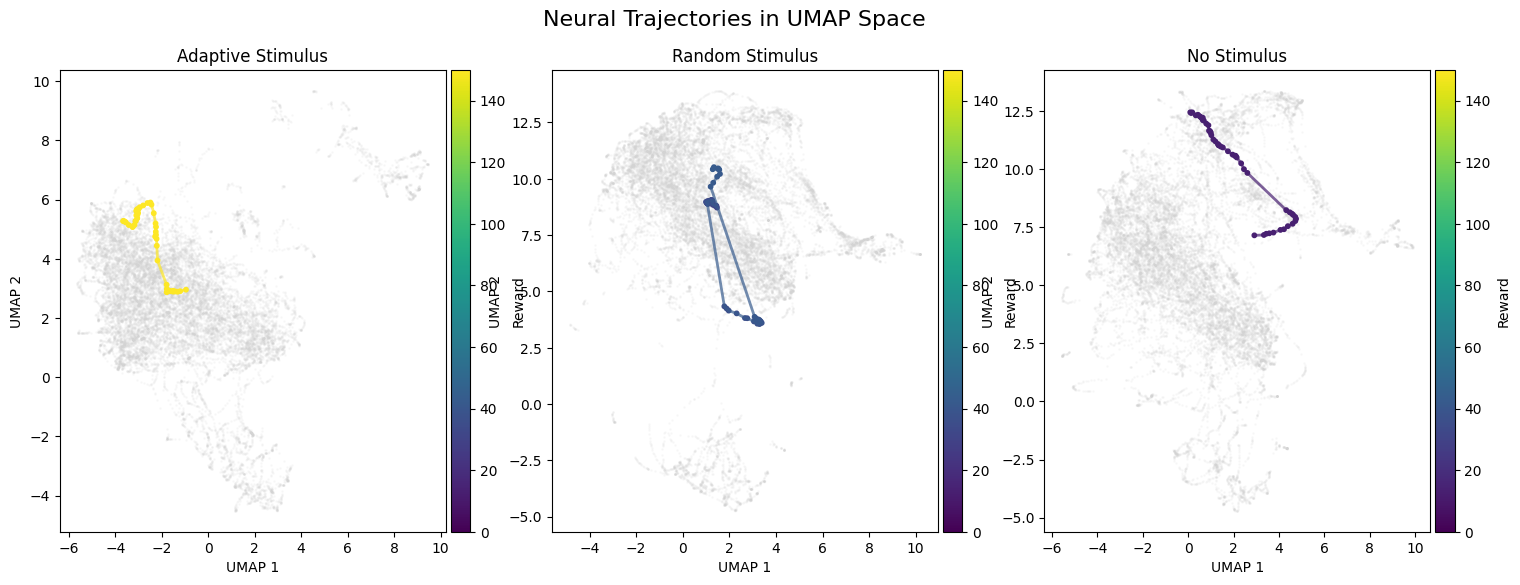

In [53]:
# saves animation to saved_plots
def umap_trajectory_rewards_anim(frame_print=1000):
    # Create the animation
    print("Creating animation...")
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Neural Trajectories in UMAP Space', fontsize=16)

    # Set titles
    axs[0].set_title('Adaptive Stimulus')
    axs[1].set_title('Random Stimulus')
    axs[2].set_title('No Stimulus')

    # Setup background points (all points to show trajectory)
    axs[0].scatter(adaptive_embedding[:, 0], adaptive_embedding[:, 1], c='lightgray', s=1, alpha=0.1)
    axs[1].scatter(random_embedding[:, 0], random_embedding[:, 1], c='lightgray', s=1, alpha=0.1)
    axs[2].scatter(none_embedding[:, 0], none_embedding[:, 1], c='lightgray', s=1, alpha=0.1)

    # Add labels
    for ax in axs:
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')

    # Create scatter plots for animation
    trail_length = 50  # How many points to keep in the trail
    vmax = 150
    reward_cmap = plt.get_cmap('viridis') # Get the colormap object
    reward_norm = plt.Normalize(vmin=0, vmax=vmax) # Create the normalization object

    scatters = [
        axs[0].scatter([], [], c=[], cmap=reward_cmap, norm=reward_norm, s=10), # Use norm here
        axs[1].scatter([], [], c=[], cmap=reward_cmap, norm=reward_norm, s=10), # Use norm here
        axs[2].scatter([], [], c=[], cmap=reward_cmap, norm=reward_norm, s=10)  # Use norm here
    ]

    # Create lines for trails - initial color doesn't matter much as it's updated
    lines = [
        axs[0].plot([], [], lw=2, alpha=0.7)[0], # Removed fixed color
        axs[1].plot([], [], lw=2, alpha=0.7)[0], # Removed fixed color
        axs[2].plot([], [], lw=2, alpha=0.7)[0]  # Removed fixed color
    ]

    # Add color bars
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    for i, ax in enumerate(axs):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        # Pass the mappable object (scatter) and norm to colorbar
        cbar = plt.colorbar(scatters[i], cax=cax, norm=reward_norm)
        cbar.set_label('Reward')

    
    # Animation initialization function
    def init():
        for scatter, line in zip(scatters, lines):
            scatter.set_offsets(np.empty((0, 2)))
            scatter.set_array(np.array([]))
            line.set_data([], [])
            # Optionally set initial line color if needed, e.g., to the lowest reward color
            # line.set_color(reward_cmap(reward_norm(0)))
        return scatters + lines

    # Animation update function
    def update(frame):
        # Use modulo to loop the animation if it gets to the end
        min_len = min(len(adaptive_embedding), len(random_embedding), len(none_embedding))
        if min_len == 0: # Avoid division by zero if any embedding is empty
            return scatters + lines
        frame = frame % min_len

        # Define the window of points to show in the trail
        window_start = max(0, frame - trail_length)
        window_end = frame + 1

        # --- Update adaptive plot ---
        mask_adaptive = np.arange(window_start, window_end)
        if len(mask_adaptive) > 0:
            current_adaptive_rewards = adaptive_rewards[mask_adaptive]
            scatters[0].set_offsets(adaptive_embedding[mask_adaptive])
            scatters[0].set_array(current_adaptive_rewards)
            lines[0].set_data(adaptive_embedding[mask_adaptive, 0], adaptive_embedding[mask_adaptive, 1])
            # Set line color based on the reward of the *last* point in the trail
            last_reward_adaptive = current_adaptive_rewards[-1]
            lines[0].set_color(reward_cmap(reward_norm(last_reward_adaptive)))
        else: # Handle empty mask case
            scatters[0].set_offsets(np.empty((0, 2)))
            scatters[0].set_array(np.array([]))
            lines[0].set_data([], [])


        # --- Update random plot ---
        mask_random = np.arange(window_start, window_end)
        if len(mask_random) > 0:
            current_random_rewards = random_rewards[mask_random]
            scatters[1].set_offsets(random_embedding[mask_random])
            scatters[1].set_array(current_random_rewards)
            lines[1].set_data(random_embedding[mask_random, 0], random_embedding[mask_random, 1])
            # Set line color based on the reward of the *last* point in the trail
            last_reward_random = current_random_rewards[-1]
            lines[1].set_color(reward_cmap(reward_norm(last_reward_random)))
        else: # Handle empty mask case
            scatters[1].set_offsets(np.empty((0, 2)))
            scatters[1].set_array(np.array([]))
            lines[1].set_data([], [])

        # --- Update none plot ---
        mask_none = np.arange(window_start, window_end)
        if len(mask_none) > 0:
            current_none_rewards = none_rewards[mask_none]
            scatters[2].set_offsets(none_embedding[mask_none])
            scatters[2].set_array(current_none_rewards)
            lines[2].set_data(none_embedding[mask_none, 0], none_embedding[mask_none, 1])
            # Set line color based on the reward of the *last* point in the trail
            last_reward_none = current_none_rewards[-1]
            lines[2].set_color(reward_cmap(reward_norm(last_reward_none)))
        else: # Handle empty mask case
            scatters[2].set_offsets(np.empty((0, 2)))
            scatters[2].set_array(np.array([]))
            lines[2].set_data([], [])


        if frame % frame_print == 0:
            print(f"Animating frame {frame}")

        return scatters + lines

        # Create animation - adjust the frames and interval as needed
    # Only animate a portion of the full dataset to keep file size reasonable
    # 15m to seconds
    max_frames = 900*50  # Adjust this for length of animation, bins at 50hz, 20ms bins
    step_size = 20      # Skip frames for speed
    animation_frames = np.arange(0, max_frames, step_size)
    print(f"Animating {len(animation_frames)} frames")

    ani = animation.FuncAnimation(
        fig, update, frames=animation_frames, 
        init_func=init, blit=True, interval=30
    )

    # Save the animation
    output_dir = Path(dataset_dir) / "animations"
    output_dir.mkdir(exist_ok=True)
    output_file = output_dir / "neural_trajectory_reward_animation.mp4"
    # If exists, add a number to the end
    if output_file.exists():
        n_existing = len(glob.glob(str(output_dir / "neural_trajectory_reward_animation_*.mp4")))
        output_file = output_dir / f"neural_trajectory_reward_animation_{n_existing+1}.mp4"

    print(f"Saving animation to {output_file}...")
    ani.save(str(output_file), writer='ffmpeg', fps=24, dpi=100)
    # plt.show()

    plt.close()

    print("Animation complete!")

# umap_trajectory_rewards_anim()

In [ ]:
def umap_trajectory_angle_anim(frame_print=1000):
    # ---------------- Create animation with pole angles ----------------
    print("Creating pole angle animation...")
    fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))
    fig2.suptitle('Neural Trajectories Colored by Pole Angle', fontsize=16)

    # Set titles
    axs2[0].set_title('Adaptive Stimulus')
    axs2[1].set_title('Random Stimulus')
    axs2[2].set_title('No Stimulus')

    # Setup background points
    axs2[0].scatter(adaptive_embedding[:, 0], adaptive_embedding[:, 1], c='lightgray', s=1, alpha=0.1)
    axs2[1].scatter(random_embedding[:, 0], random_embedding[:, 1], c='lightgray', s=1, alpha=0.1)
    axs2[2].scatter(none_embedding[:, 0], none_embedding[:, 1], c='lightgray', s=1, alpha=0.1)

    # Add labels
    for ax in axs2:
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')

    # Create scatter plots for animation
    scatters2 = [
        axs2[0].scatter([], [], c=[], cmap=angle_cmap, norm=angle_norm, s=10),
        axs2[1].scatter([], [], c=[], cmap=angle_cmap, norm=angle_norm, s=10),
        axs2[2].scatter([], [], c=[], cmap=angle_cmap, norm=angle_norm, s=10)
    ]

    # Create lines for trails
    lines2 = [
        axs2[0].plot([], [], c='black', lw=2, alpha=0.7)[0],
        axs2[1].plot([], [], c='black', lw=2, alpha=0.7)[0],
        axs2[2].plot([], [], c='black', lw=2, alpha=0.7)[0]
    ]

    # Add color bars
    for i, ax in enumerate(axs2):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatters2[i], cax=cax)
        cbar.set_label('Pole Angle')

    # Animation initialization function
    def init2():
        for scatter, line in zip(scatters2, lines2):
            scatter.set_offsets(np.empty((0, 2)))
            scatter.set_array(np.array([]))
            line.set_data([], [])
        return scatters2 + lines2

    # Animation update function
    def update2(frame):
        # Use modulo to loop the animation if it gets to the end
        frame = frame % min(len(adaptive_embedding), len(random_embedding), len(none_embedding))
        
        # Define the window of points to show in the trail
        window_start = max(0, frame - trail_length)
        window_end = frame + 1
        
        # Update adaptive plot
        mask_adaptive = np.arange(window_start, window_end)
        scatters2[0].set_offsets(adaptive_embedding[mask_adaptive])
        scatters2[0].set_array(adaptive_angles[mask_adaptive])
        lines2[0].set_data(adaptive_embedding[mask_adaptive, 0], adaptive_embedding[mask_adaptive, 1])
        
        # Update random plot
        mask_random = np.arange(window_start, window_end)
        scatters2[1].set_offsets(random_embedding[mask_random])
        scatters2[1].set_array(random_angles[mask_random])
        lines2[1].set_data(random_embedding[mask_random, 0], random_embedding[mask_random, 1])
        
        # Update none plot
        mask_none = np.arange(window_start, window_end)
        scatters2[2].set_offsets(none_embedding[mask_none])
        scatters2[2].set_array(none_angles[mask_none])
        lines2[2].set_data(none_embedding[mask_none, 0], none_embedding[mask_none, 1])
        
        if frame % frame_print == 0:
            print(f"Animating pole angle frame {frame}")
        
        return scatters2 + lines2

    # Create animation for pole angles
    ani2 = animation.FuncAnimation(
        fig2, update2, frames=animation_frames, 
        init_func=init2, blit=True, interval=30
    )

    # Save the animation
    output_dir = Path(dataset_dir) / "animations"
    output_dir.mkdir(exist_ok=True)
    output_file = output_dir / "neural_trajectory_angle_animation.mp4"
    # If exists, add a number to the end
    if output_file.exists():
        n_existing = len(glob.glob(str(output_dir / "neural_trajectory_angle_animation_*.mp4")))
        output_file = output_dir / f"neural_trajectory_angle_animation_{n_existing+1}.mp4"

    print(f"Saving animation to {output_file}...")
    ani.save(str(output_file), writer='ffmpeg', fps=24, dpi=100)
    # plt.show()

    plt.close()

    print("All visualizations complete!")

## <font color="green"> Bonus Stuff

In [45]:
all_sds = {
    "Baseline": baseline_sd,
    "Adaptive": adaptive_sd,
    "Random": random_sd,
    "None": none_sd
}
infos = {}
max_fr = 0 # To normalize colorbars later
max_n = 0 # Keep track of max number of neurons for STTC padding

#print("Calculating metrics (FR, STTC)...")
for name, sd in all_sds.items():
    info = {}
    # --- Firing Rate ---
    if sd.N > 0:
        fr = sd.rates(unit='Hz')
        info['fr'] = fr
        if fr.size > 0: # Check if fr is not empty
             current_max_fr = fr.max()
             if current_max_fr > max_fr:
                 max_fr = current_max_fr
        else:
             info['fr'] = np.zeros(sd.N) # Assign zeros if no spikes
    else:
        info['fr'] = np.array([]) # Empty array if no neurons

    # Update max neuron count
    if sd.N > max_n:
        max_n = sd.N

    # --- STTC ---
    try:
        if sd.N > 1: # Need at least 2 neurons and 2 spikes
            sttc = sd.spike_time_tilings()
            # Ensure diagonal is NaN or 1 (often it's calculated as 1)
            np.fill_diagonal(sttc, np.nan) # Set diagonal to NaN for visualization
        elif sd.N == 1:
             sttc = np.full((1, 1), np.nan) # Single neuron case
        else:
            sttc = np.empty((0, 0)) # No neurons case
    except Exception as e:
        print(f"Warning: Could not calculate STTC for {name}: {e}")
        sttc = np.full((sd.N, sd.N), np.nan) # Assign NaN on error

    info['sttc'] = sttc
    infos[name] = info

In [46]:
def firingRatePlots():
    # Enable constrained_layout=True
    fig_fr, axs_fr = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True,
                                constrained_layout=True)
    axs_fr = axs_fr.flatten()
    fig_fr.suptitle('Average Firing Rate per Neuron', fontsize=16)

    norm_fr = mcolors.Normalize(vmin=0, vmax=max_fr if max_fr > 0 else 1)
    cmap_fr = plt.get_cmap('magma')
    sm_fr = plt.cm.ScalarMappable(norm=norm_fr, cmap=cmap_fr)

    plot_names = list(all_sds.keys())
    plotted_something_fr = False
    for i, ax in enumerate(axs_fr):
        name = plot_names[i]
        if name in infos and infos[name]['fr'].size > 0 and spike_locs.size > 0:
            current_n = infos[name]['fr'].shape[0]
            if spike_locs.shape[0] == current_n:
                sc = ax.scatter(spikes_x, spikes_y, c=infos[name]['fr'], cmap=cmap_fr, norm=norm_fr, s=40, alpha=0.9)
                plotted_something_fr = True
            elif spike_locs.shape[0] > current_n:
                print(f"Warning: Mismatch in neuron count for FR plot {name}. Plotting subset.")
                sc = ax.scatter(spikes_x[:current_n], spikes_y[:current_n], c=infos[name]['fr'], cmap=cmap_fr, norm=norm_fr, s=40, alpha=0.9)
                plotted_something_fr = True
            else:
                print(f"Error: Not enough spike locations for FR plot {name}.")
                ax.set_title(f"{name} (Plotting Error)")
                ax.axis('off')
                continue

            ax.set_title(name)
            if i >= 2: ax.set_xlabel('X Position (µm)')
            if i % 2 == 0: ax.set_ylabel('Y Position (µm)')
        else:
            ax.set_title(f"{name} (No Data)")
            ax.axis('off')

    # Add a single colorbar for the figure IF something was plotted
    if plotted_something_fr:
        # Constrained layout works well with ax=list
        # Adjust shrink and aspect as needed
        fig_fr.colorbar(sm_fr, ax=axs_fr.tolist(), shrink=0.6, aspect=25, label='Firing Rate (Hz)')
    else:
        print("Warning: No Firing Rate data plotted, skipping colorbar.")

    # No plt.tight_layout() needed when using constrained_layout=True
    plt.show()

# firingRatePlots()

In [47]:
def fourSTTCs():
    # ====== Plot 3: Spike Time Tiling Coefficient (STTC) ======
    # Enable constrained_layout=True
    fig_sttc, axs_sttc = plt.subplots(2, 2, figsize=(10, 9),
                                    constrained_layout=True)
    axs_sttc = axs_sttc.flatten()
    fig_sttc.suptitle('Spike Time Tiling Coefficient (STTC) Matrix', fontsize=16)

    norm_sttc = mcolors.Normalize(vmin=0, vmax=1)
    cmap_sttc = plt.get_cmap('viridis')
    cmap_sttc.set_bad(color='grey')

    last_im = None
    for i, ax in enumerate(axs_sttc):
        name = plot_names[i]
        if name in infos and infos[name]['sttc'].size > 0:
            im = ax.imshow(infos[name]['sttc'], cmap=cmap_sttc, norm=norm_sttc, origin='lower', interpolation='nearest', aspect='auto')
            last_im = im
            ax.set_title(name)
            if i >= 2: ax.set_xlabel('Neuron Index')
            if i % 2 == 0: ax.set_ylabel('Neuron Index')
        else:
            ax.set_title(f"{name} (No STTC Data)")
            ax.axis('off')

    # Add a single colorbar, referencing the last image object plotted
    if last_im is not None:
        # Constrained layout works well with ax=list
        fig_sttc.colorbar(last_im, ax=axs_sttc.tolist(), shrink=0.6, aspect=25, label='STTC')
    else:
        print("Warning: No STTC data plotted, skipping colorbar.")

    # No plt.tight_layout() needed when using constrained_layout=True
    plt.show()

#fourSTTCs()

In [48]:
def fourRasters():
     # ====== Plot 4: Raster Plots ======
     # Adjusted figsize for potentially better width/height ratio
     fig_raster, axs_raster = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
     axs_raster = axs_raster.flatten()
     fig_raster.suptitle('Raster Plot (20s Window)', fontsize=16)

     # Define time window (start and end in seconds)
     raster_start_s = 220
     raster_end_s = 290

     for i, ax in enumerate(axs_raster):
          name = plot_names[i]
          sd = all_sds[name]
          if sd.N > 0:
               idces, times = sd.idces_times()
               times_sec = times / 1000.0 # Convert ms to seconds
               mask = (times_sec >= raster_start_s) & (times_sec <= raster_end_s)
               if np.any(mask): # Check if there are any spikes in the window
                    ax.scatter(times_sec[mask], idces[mask], s=1.5, c='k', marker='|', alpha=0.8, linewidths=0.5) # Slightly thicker markers
                    ax.set_title(name)
                    ax.set_xlim(raster_start_s, raster_end_s)
                    if i >= 2: # Add x-label only to bottom row
                         ax.set_xlabel('Time (s)')
                    if i % 2 == 0: # Add y-label only to left column
                         ax.set_ylabel('Neuron Index')
                    ax.invert_yaxis() # Typically neuron 0 is at the top
                    # Optionally set y-limits based on max neuron index if needed
                    # ax.set_ylim(sd.N, -1)
               else:
                    ax.set_title(f"{name} (No Spikes in Window)")
                    ax.set_xlim(raster_start_s, raster_end_s)
                    if i >= 2: ax.set_xlabel('Time (s)')
                    if i % 2 == 0: ax.set_ylabel('Neuron Index')
                    # ax.set_yticks([]) # Remove y-ticks if no spikes
          else:
               ax.set_title(f"{name} (No Spikes)")
               ax.axis('off')

     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
     plt.show()

#fourRasters()

# <font color="red">Bookend

In [49]:
now = datetime.now(Timezone)
printNow = now.strftime("%Y/%m/%d %H:%M:%S")

print(f"Done at: {printNow}")

Done at: 2025/05/17 21:42:47
